In [1]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import glob
import os
import json

In [2]:
!pip install torch transformers pandas scikit-learn 

In [3]:
!git clone https://github.com/BigRoddy/CMIN-Dataset.git

Cloning into 'CMIN-Dataset'...
remote: Enumerating objects: 350438, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 350438 (delta 0), reused 0 (delta 0), pack-reused 350411 (from 1)
Receiving objects: 100% (350438/350438), 404.05 MiB | 23.38 MiB/s, done.
Resolving deltas: 100% (41022/41022), done.
Updating files: 100% (369958/369958), done.


In [4]:
stock_path = "/content/CMIN-Dataset/CMIN-US/price/processed/AAPL.txt"
news_path ="/content/CMIN-Dataset/CMIN-US/news/preprocessed/AAPL"

In [5]:
#news_data = pd.read_csv(news_path)
stock_data = pd.read_csv(stock_path, sep='\t', header = None)

In [6]:
stock_data.iloc[:, 1] = stock_data.iloc[:, 1].astype(float)

In [7]:
def label_price(df):
    df['label'] = df.iloc[:, 1].apply(lambda x: 1 if x > 0 else 0)
    return df

stock_data.iloc[:, 1] = stock_data.iloc[:, 1].astype(float)
stock_df = label_price(stock_data)
stock_df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Label']
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2018-01-03,-0.000174,0.013928,0.013059,0.015952,-0.000174,118071600,0
1,2018-01-04,0.004645,0.000058,-0.006187,0.000698,0.004645,89738400,1
2,2018-01-05,0.011385,0.005216,0.010953,0.005637,0.011385,94640000,1
3,2018-01-08,-0.003714,0.005247,0.001369,0.005085,-0.003714,82271200,0
4,2018-01-09,-0.000115,0.001147,-0.003132,-0.002990,-0.000115,86336000,0
...,...,...,...,...,...,...,...,...
997,2021-12-17,-0.006502,-0.052153,-0.042343,-0.006208,-0.006502,195432700,0
998,2021-12-20,-0.008122,-0.009710,-0.016660,-0.013142,-0.008122,107499100,0
999,2021-12-21,0.019087,0.019491,0.015359,0.009913,0.019087,91185900,1
1000,2021-12-22,0.015319,0.008627,0.015358,0.017916,0.015319,92135300,1


In [8]:
min_value = stock_df.iloc[:, 0].min()
max_value = stock_df.iloc[:, 0].max()
print(f"Start date: {min_value}")
print(f"End date: {max_value}")

Start date: 2018-01-03 00:00:00
End date: 2021-12-23 00:00:00


In [9]:
# Step 1: Set up file paths
json_directory = '/content/CMIN-Dataset/CMIN-US/news/preprocessed/AAPL/*'
# txt_file_path = 'path/to/stock_prices.txt'

# Step 2: Load JSON files
json_files = glob.glob(json_directory)
json_dataframes = []

for file in sorted(json_files):
    try:
        with open(file, 'r') as f:
            json_data = [json.loads(line) for line in f if line.strip()]  # Read each line
        df = pd.DataFrame(json_data)
        json_dataframes.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

combined_json_df = pd.concat(json_dataframes, ignore_index=True)
# combined_json_df = combined_json_df['created_at'].split(" ")[0]
combined_json_df['created_at'] = pd.to_datetime(combined_json_df['created_at'])

# Step 2: Extract the date
combined_json_df['created_at'] = combined_json_df['created_at'].dt.date
combined_json_df.rename(columns={'created_at': 'Date'}, inplace=True)

# Combine text by date
# combined_json_df = combined_json_df.groupby('date')['text'].agg(lambda x: ' '.join(x)).reset_index()
combined_json_df = combined_json_df.groupby('Date')['text'].agg(lambda x: ' '.join([' '.join(item) for item in x])).reset_index()

combined_json_df['Date'] = pd.to_datetime(combined_json_df['Date'])
combined_json_df


,Date,text
0,2018-01-01,"Forget Your iPhone X, Ignore The Samsung And P..."
1,2018-01-02,Cramer reflects on how Trump's actions are fue...
2,2018-01-03,Apple Acquires Canadian Software Startup Wedne...
3,2018-01-04,Jimmy Iovine to leave Apple Music in August - ...
4,2018-01-05,CES kicks off with no lead women speakers or c...
...,...,...
1422,2021-12-27,Apple shutters 11 stores in New York City amid...
1423,2021-12-28,"Stock Market: As interest rates go up, options..."
1424,2021-12-29,The Dow's New High Is Hiding This Key Market R...
1425,2021-12-30,The Unsung Winners and Biggest Losers of China...


In [10]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2018-01-03,-0.000174,0.013928,0.013059,0.015952,-0.000174,118071600,0
1,2018-01-04,0.004645,0.000058,-0.006187,0.000698,0.004645,89738400,1
2,2018-01-05,0.011385,0.005216,0.010953,0.005637,0.011385,94640000,1
3,2018-01-08,-0.003714,0.005247,0.001369,0.005085,-0.003714,82271200,0
4,2018-01-09,-0.000115,0.001147,-0.003132,-0.002990,-0.000115,86336000,0
...,...,...,...,...,...,...,...,...
997,2021-12-17,-0.006502,-0.052153,-0.042343,-0.006208,-0.006502,195432700,0
998,2021-12-20,-0.008122,-0.009710,-0.016660,-0.013142,-0.008122,107499100,0
999,2021-12-21,0.019087,0.019491,0.015359,0.009913,0.019087,91185900,1
1000,2021-12-22,0.015319,0.008627,0.015358,0.017916,0.015319,92135300,1


In [11]:
# Step 3: Load the stock prices text file
# Adjust this depending on the structure of your txt file
stock_prices_df = stock_df

# Step 4: Merge DataFrames on date
final_df = pd.merge(combined_json_df, stock_prices_df, on='Date', how='outer')  # or 'inner' based on your needs

# Optional: Save the final DataFrame to a file
# final_df.to_csv('combined_data.csv', index=False)

final_df.dropna(inplace=True)
final_df

,Date,text,Open,High,Low,Close,Adj Close,Volume,Label
2,2018-01-03,Apple Acquires Canadian Software Startup Wedne...,-0.000174,0.013928,0.013059,0.015952,-0.000174,118071600.0,0.0
3,2018-01-04,Jimmy Iovine to leave Apple Music in August - ...,0.004645,0.000058,-0.006187,0.000698,0.004645,89738400.0,1.0
4,2018-01-05,CES kicks off with no lead women speakers or c...,0.011385,0.005216,0.010953,0.005637,0.011385,94640000.0,1.0
7,2018-01-08,Semiconductor Industry Meltdown Exposes Securi...,-0.003714,0.005247,0.001369,0.005085,-0.003714,82271200.0,0.0
8,2018-01-09,Canada's competition watchdog settles with Har...,-0.000115,0.001147,-0.003132,-0.002990,-0.000115,86336000.0,0.0
...,...,...,...,...,...,...,...,...,...
1428,2021-12-17,Apple (AAPL) Stock Moves -0.65%: What You Shou...,-0.006502,-0.052153,-0.042343,-0.006208,-0.006502,195432700.0,0.0
1431,2021-12-20,Amazon Slides Below Support Level as Big Tech ...,-0.008122,-0.009710,-0.016660,-0.013142,-0.008122,107499100.0,0.0
1432,2021-12-21,"Japan Pressed to Spend Billions, Cut Tax to Re...",0.019087,0.019491,0.015359,0.009913,0.019087,91185900.0,1.0
1433,2021-12-22,"After Austin blow, Cooper's office kept engagi...",0.015319,0.008627,0.015358,0.017916,0.015319,92135300.0,1.0


# Preprocessing

In [12]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy

nltk.download('punkt')
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load Spacy model for lemmatization
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Check if text is a list and join it if necessary
    if isinstance(text, list):
        text = ' '.join(text)

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and perform lemmatization
    tokens = [token.lemma_ for token in nlp(" ".join([word for word in tokens if word not in stop_words]))]

    # Handle empty strings
    if not tokens:  # Check if tokens list is empty after preprocessing
        return " "  # Replace empty list with a space to avoid NaN

    # Join tokens back to string
    return " ".join(tokens)

# Apply preprocessing to the correct DataFrame (final_df)
final_df['text'] = final_df['text'].astype(str).apply(preprocess_text)

final_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Date,text,Open,High,Low,Close,Adj Close,Volume,Label
2,2018-01-03,apple acquire canadian software startup wednes...,-0.000174,0.013928,0.013059,0.015952,-0.000174,118071600.0,0.0
3,2018-01-04,jimmy iovine leave apple music august billboar...,0.004645,0.000058,-0.006187,0.000698,0.004645,89738400.0,1.0
4,2018-01-05,ces kick lead woman speaker code conduct crowd...,0.011385,0.005216,0.010953,0.005637,0.011385,94640000.0,1.0
7,2018-01-08,semiconductor industry meltdown expose securit...,-0.003714,0.005247,0.001369,0.005085,-0.003714,82271200.0,0.0
8,2018-01-09,canadas competition watchdog settle harpercoll...,-0.000115,0.001147,-0.003132,-0.002990,-0.000115,86336000.0,0.0
...,...,...,...,...,...,...,...,...,...
1428,2021-12-17,apple aapl stock move 065 know cascends ross t...,-0.006502,-0.052153,-0.042343,-0.006208,-0.006502,195432700.0,0.0
1431,2021-12-20,amazon slide support level big tech weakness c...,-0.008122,-0.009710,-0.016660,-0.013142,-0.008122,107499100.0,0.0
1432,2021-12-21,japan press spend billion cut tax revive chip ...,0.019087,0.019491,0.015359,0.009913,0.019087,91185900.0,1.0
1433,2021-12-22,austin blow coopers office keep engage apple n...,0.015319,0.008627,0.015358,0.017916,0.015319,92135300.0,1.0


In [13]:
final_df['text'].isnull().sum()

0

In [14]:
from collections import Counter
# Step 4: Count word frequencies
word_counts = Counter()
for tokens in final_df['text']:
    word_counts.update(tokens)

# Get the most common words
most_common_words = word_counts.most_common(10)  # Change the number to get more or fewer words
print(most_common_words)

[(' ', 432043), ('e', 257259), ('a', 203798), ('o', 159722), ('t', 158936), ('r', 141154), ('i', 134527), ('l', 129946), ('s', 128955), ('n', 128179)]


# Knowledge Graph

In [15]:
!pip install beautifulsoup4

In [16]:
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [17]:
first_row_text = final_df['text'].iloc[0]
print(first_row_text)

apple acquire canadian software startup wednesday apple rumor lg supply ole display 2018 iphone 6 big prediction smart homesecurity space 2018 sec mix message apple shareholder proposal activist say 3 huge merger acquisition could happen 2018 netflix break bright prospect film overall business advanced micro devices inc stock surge today alphabet inc still massive growth ahead nasdaq 7k technician believe sec mix message apple shareholder proposal activist say sec mix message apple shareholder proposal activist say apple battery replacement offer reduce 2018 iphone sale barclay spotify survive 16 billion music publisher lawsuit nasdaq lead bitcoin etf hold firm apple stock double apple reese witherspoon develop another original tv series nasdaq lead bitcoin etf hold firm apple stock double apple japanese candlestick perspective key spec apple 2018 iphone reveal go long advanced micro devices inc redhot sector notable wednesday option activity aapl intc amd augmented reality get reality

In [18]:
nlp = spacy.load('en_core_web_sm')

doc = nlp(first_row_text)

for tok in doc:
    print(tok.text, "...", tok.dep_)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


apple ... nsubj
acquire ... ccomp
canadian ... amod
software ... dobj
startup ... compound
wednesday ... compound
apple ... compound
rumor ... nmod
lg ... nmod
supply ... nmod
ole ... compound
display ... nmod
2018 ... nummod
iphone ... nmod
6 ... nummod
big ... amod
prediction ... nmod
smart ... amod
homesecurity ... compound
space ... appos
2018 ... nummod
sec ... compound
mix ... compound
message ... compound
apple ... compound
shareholder ... compound
proposal ... compound
activist ... nsubj
say ... ROOT
3 ... nummod
huge ... amod
merger ... compound
acquisition ... nsubj
could ... aux
happen ... ccomp
2018 ... nummod
netflix ... nsubj
break ... ccomp
bright ... amod
prospect ... compound
film ... dobj
overall ... amod
business ... nmod
advanced ... compound
micro ... compound
devices ... compound
inc ... compound
stock ... compound
surge ... appos
today ... npadvmod
alphabet ... compound
inc ... poss
still ... advmod
massive ... amod
growth ... dobj
ahead ... advmod
nasdaq ... com

In [19]:
import re
import bs4
import requests

from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [20]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [21]:
get_entities(first_row_text)

['large  iphone', 'ce 2018 remix prediction apple']

In [22]:
entity_pairs = []

for i in tqdm(final_df["text"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 987/987 [01:01<00:00, 16.09it/s]


In [23]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    # Add the pattern to the matcher
    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    if matches:  # Check if there are any matches
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]
        return span.text
    else:
        return ""

# Apply to each sentence in the DataFrame
relations = [get_relation(i) for i in tqdm(final_df['text'])]


100%|██████████| 987/987 [00:58<00:00, 16.85it/s]


In [24]:
pd.Series(relations).value_counts()[:10]

,count
say,284
know,25
make,25
expect,22
buy,17
hit,14
think,13
see,10
include,9
watch,9


# Build knowledge graph

In [25]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,large iphone,ce 2018 remix prediction apple,say
1,old battery cramer,big winner loser,say
2,890 apple battery fix,iphone sale,say
3,8 chip competitor what,8 chip competitor iphone,say
4,youth phone addiction,large investor,say
...,...,...,...
982,100 amzn tsla nvda,nosebleed stock valuation,perform
983,dangerous rally omicron fears,xi book reuter report,continue
984,first day trading ipo,multiyear rate plan,want
985,electric vehicle company,2022,make


In [26]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

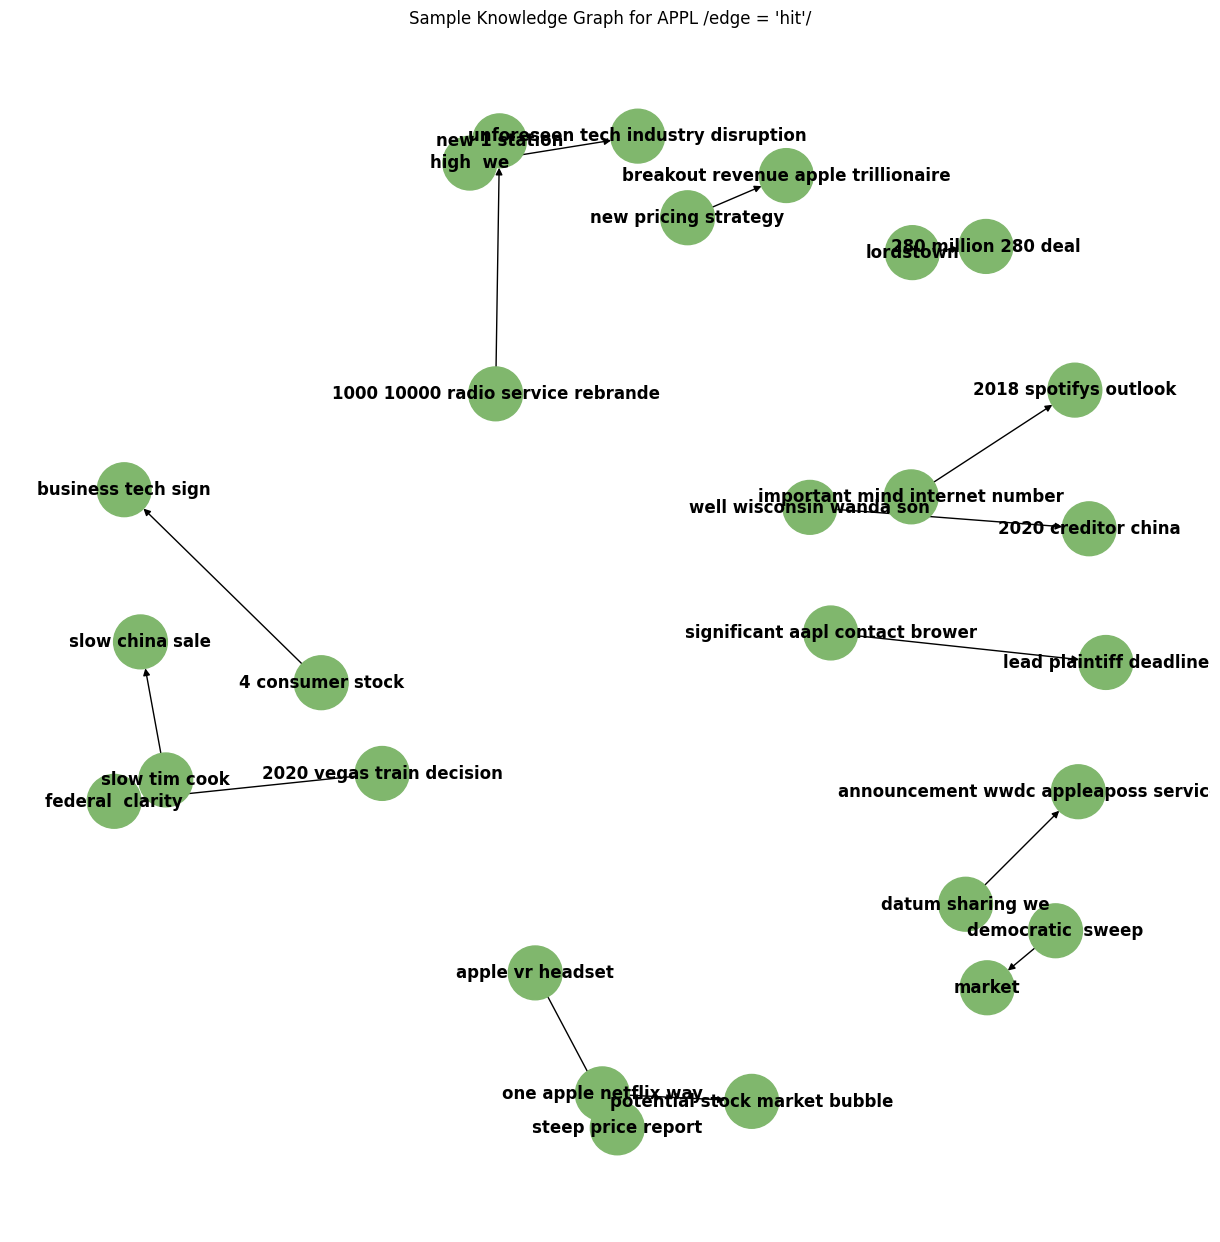

In [27]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="hit"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

# Create a color map based on node attributes
node_color_map = []
# For example:
node_types = {node: 'Type1' if node in ['node1', 'node2'] else 'Type2' for node in G.nodes()} # Replace with your logic to determine node types


# Create a color map based on node attributes
node_color_map = []

# Define colors for each node type
color_dict = {'Type1': 'blue', 'Type2': '#80b76d', 'Type3': 'red'}

for node in G.nodes():
    node_color_map.append(color_dict.get(node_types.get(node, 'gray')))  # Default color is gray if node type not found

# Draw the graph with specified colors
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color=node_color_map, node_size=1500,
        edge_cmap=plt.cm.Blues, pos=pos, font_weight='bold')

plt.title("Sample Knowledge Graph for APPL /edge = 'hit'/")
plt.show()

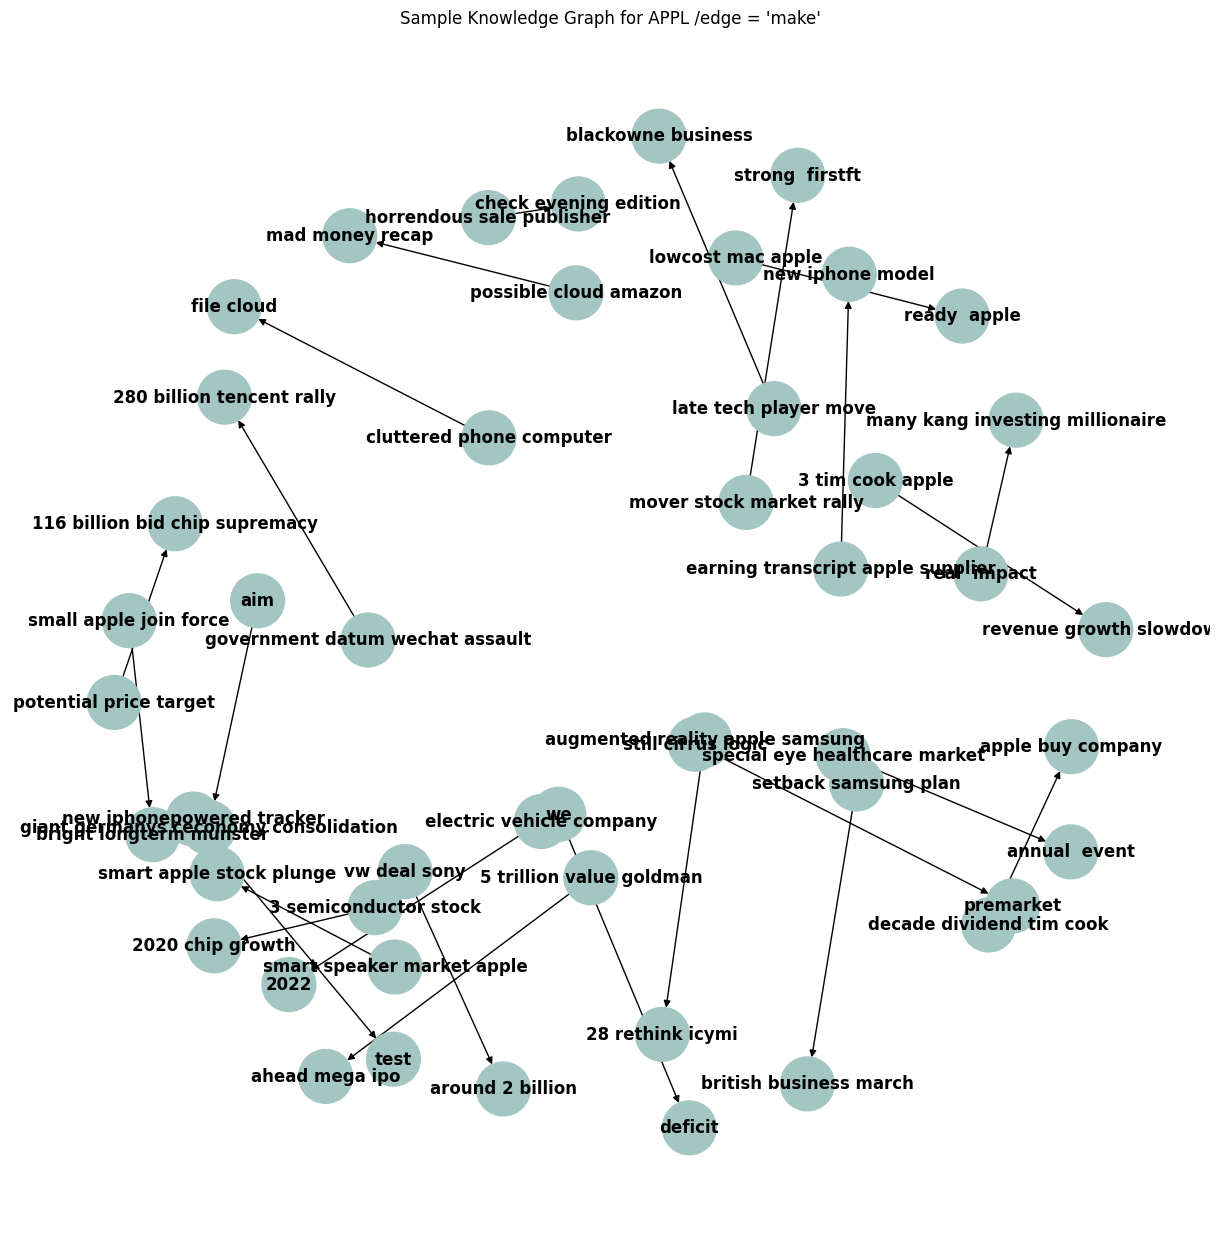

In [28]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="make"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

# Create a color map based on node attributes
node_color_map = []
# For example:
node_types = {node: 'Type1' if node in ['node1', 'node2'] else 'Type2' for node in G.nodes()} # Replace with your logic to determine node types


# Create a color map based on node attributes
node_color_map = []

# Define colors for each node type
color_dict = {'Type1': 'blue', 'Type2': '#a3c6c2', 'Type3': 'red'}

for node in G.nodes():
    node_color_map.append(color_dict.get(node_types.get(node, 'gray')))  # Default color is gray if node type not found

# Draw the graph with specified colors
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color=node_color_map, node_size=1500,
        edge_cmap=plt.cm.Blues, pos=pos, font_weight='bold')

plt.title("Sample Knowledge Graph for APPL /edge = 'make'")
plt.show()

# Financial metrics data

In [29]:
import yfinance as yf

# Specify the company ticker symbol
ticker_symbol = 'AAPL'  # Example: Apple Inc.

# Fetch the financial data
company = yf.Ticker(ticker_symbol)

# Get the financial metrics (e.g., income statement, balance sheet, cash flow)
income_statement = company.financials
balance_sheet = company.balance_sheet
cash_flow = company.cashflow

# You can also get specific metrics, e.g., market cap, P/E ratio, etc.
market_cap = company.info['marketCap']
pe_ratio = company.info['trailingPE']

In [30]:
%pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.1/562.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 kB 10.6 MB/s eta 0:00:00


In [31]:
from rdflib import Graph, URIRef, Literal, Namespace

# Create a new graph
g = Graph()

# Define namespaces
EX = Namespace("http://example.org/")

# Create a URI for the company
company_uri = URIRef(EX[ticker_symbol])

# Add financial metrics as properties
g.add((company_uri, EX.marketCap, Literal(market_cap)))
g.add((company_uri, EX.trailingPERatio, Literal(pe_ratio)))
g.add((company_uri, EX.income_statement, Literal(income_statement)))
g.add((company_uri, EX.balance_sheet, Literal(balance_sheet)))
g.add((company_uri, EX.cash_flow, Literal(cash_flow)))

income_statement


,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.147,0.162,0.133,0.144
Normalized EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
Net Income From Continuing Operation Net Minority Interest,96995000000.0,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11519000000.0,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,214137000000.0,223546000000.0,212981000000.0,169559000000.0
EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
EBIT,117669000000.0,122034000000.0,111852000000.0,69964000000.0
Net Interest Income,-183000000.0,-106000000.0,198000000.0,890000000.0
Interest Expense,3933000000.0,2931000000.0,2645000000.0,2873000000.0


In [32]:
# # Add more financial metrics
# for index, row in income_statement.iterrows():
#     # Access 'Total Revenue' as a column name, not an index value
#     g.add((company_uri, EX.incomeStatement, Literal(f"{index}: {row.get('Total Revenue', 'N/A')}")))  # Use get to handle potential missing values
#     #print(f"{index}: {row['Total Revenue']}")

# for index, row in balance_sheet.iterrows():
#     g.add((company_uri, EX.balanceSheet, Literal(f"{index}: {row.get('Total Assets', 'N/A')}")))

# for index, row in cash_flow.iterrows():
#     g.add((company_uri, EX.cashFlow, Literal(f"{index}: {row.get('Operating Cash Flow', 'N/A')}")))

# Serialize the graph to a file
g.serialize(destination='knowledge_graph.rdf', format='xml')

print("Knowledge graph created and saved as knowledge_graph.rdf")

Knowledge graph created and saved as knowledge_graph.rdf


# Query Knowledge Graph

In [34]:
from rdflib import Graph

# Load the graph from the file
g = Graph()
g.parse("knowledge_graph.rdf", format="xml")

<Graph identifier=N5bacd39906dd4ae9988a76b0d3ca3bd8 (<class 'rdflib.graph.Graph'>)>

In [35]:
from rdflib import Graph, Namespace, URIRef

# Load the graph from the file
g = Graph()
g.parse("knowledge_graph.rdf", format="xml")

# Define the namespace
EX = Namespace("http://example.org/")

# Specify the ticker symbol
ticker_symbol = "AAPL"  # Replace with your actual ticker symbol

# Create the company URI
company_uri = URIRef(EX[ticker_symbol])


In [39]:
query = f"""
PREFIX ex: <http://example.org/>

SELECT ?value
WHERE {{
    <{company_uri}> ex:trailingPERatio ?value
}}
"""

# Execute the query
results = g.query(query)

# Print the results
for row in results:
    print(f"trailingPERatio: {row.value}")


trailingPERatio: 35.714287


In [37]:
query = f"""
PREFIX ex: <http://example.org/>

SELECT ?value
WHERE {{
    <{company_uri}> ex:marketCap ?value
}}
"""

# Execute the query
results = g.query(query)

# Print the results
for row in results:
    print(f"Market Cap: {row.value}")

Market Cap: 3572963475456
